#  OPTİMİZE VERSİYON: RF vs XGBoost


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

BASE_DIR = Path("/content/drive/MyDrive/SA_CropType_SourceCoop")
TRAIN_DIR = BASE_DIR / "train"
LABELS_DIR = TRAIN_DIR / "labels"
S2_DIR = TRAIN_DIR / "imagery" / "s2"
OUT_DIR = BASE_DIR / "outputs"
META_DIR = OUT_DIR / "meta"
FIG_DIR = OUT_DIR / "figures"
TAB_DIR = OUT_DIR / "tables"

for d in [OUT_DIR, META_DIR, FIG_DIR, TAB_DIR]:
    d.mkdir(parents=True, exist_ok=True)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)

!pip install xgboost -q
import xgboost as xgb
import time
from datetime import datetime

print("✅ Kurulum tamam!")
print(f"⏰ Başlangıç: {datetime.now().strftime('%H:%M:%S')}")

✅ Kurulum tamam!
⏰ Başlangıç: 18:00:15


## 📊 TILE SEÇİMİ (100 Tile)

In [ ]:
tfc = pd.read_csv(META_DIR / "tile_field_crop_table.csv")

TARGET_CROPS = [
    "Wine grapes",
    "Wheat",
    "Planted pastures (perennial)",
    "Lucerne/Medics"
]

tfc_target = tfc[tfc['crop'].isin(TARGET_CROPS)].copy()

print(f"📊 Orijinal veri:")
print(f"  Toplam field: {tfc_target['field_id'].nunique():,}")
print(f"  Toplam tile: {tfc_target['tile_id'].nunique()}")

# Tile istatistikleri
tile_stats = tfc_target.groupby('tile_id').agg({
    'field_id': 'nunique',
    'crop': lambda x: list(x.unique())
}).reset_index()

tile_stats.columns = ['tile_id', 'num_fields', 'crops']
tile_stats['num_crops'] = tile_stats['crops'].apply(len)
tile_stats = tile_stats.sort_values('num_fields', ascending=False)

print(f"\n🏆 En zengin 10 tile:")
print(tile_stats.head(10)[['tile_id', 'num_fields', 'num_crops']])

# ============================================================
# ÖNEMLİ: 100 TILE SEÇİMİ
# ============================================================
TOP_N_TILES = 100  # 50 → 100 (2x daha fazla)

top_tiles = tile_stats.head(TOP_N_TILES)['tile_id'].values
tfc_selected = tfc_target[tfc_target['tile_id'].isin(top_tiles)].copy()

print(f"\n✅ Seçilen: En zengin {TOP_N_TILES} tile")
print(f"  Toplam field: {tfc_selected['field_id'].nunique():,}")
print(f"\n🌾 Sınıf dağılımı:")
for crop in TARGET_CROPS:
    count = len(tfc_selected[tfc_selected['crop']==crop])
    print(f"  {crop}: {count:,}")

# Kaydet
tfc_selected.to_csv(META_DIR / "tfc_selected_top100.csv", index=False)
print(f"\n💾 Kaydedildi: tfc_selected_top100.csv")

📊 Orijinal veri:
  Toplam field: 11,227
  Toplam tile: 377

🏆 En zengin 10 tile:
     tile_id  num_fields  num_crops
23       127         411          3
264     1303         350          3
235     1264         321          2
126     1129         311          3
328     1385         219          3
196     1214         213          3
68      1049         199          3
221     1246         179          3
88      1079         178          3
296     1342         173          3

✅ Seçilen: En zengin 100 tile
  Toplam field: 8,228

🌾 Sınıf dağılımı:
  Wine grapes: 4,809
  Wheat: 1,050
  Planted pastures (perennial): 1,326
  Lucerne/Medics: 1,043

💾 Kaydedildi: tfc_selected_top100.csv


## 🛠️ ÖZELLİK ÇIKARIMI (15 Tarih)

In [ ]:
def smart_date_selection(tile_dir, max_dates=15):
    """
    AKILLI TARİH SEÇİMİ: Aylara dağıtılmış tarihler
    """
    all_dates = sorted([d for d in tile_dir.iterdir() if d.is_dir()])
    if len(all_dates) == 0:
        return [], {}

    # Tarih bilgilerini parse et
    date_info = []
    for date_folder in all_dates:
        try:
            parts = date_folder.name.split('_')
            if len(parts) >= 3:
                year = int(parts[0])
                month = int(parts[1])
                date_info.append({
                    'path': date_folder,
                    'year_month': f"{year}_{month:02d}"
                })
        except:
            continue

    if len(date_info) == 0:
        return all_dates[:max_dates], {}

    df = pd.DataFrame(date_info)
    monthly_counts = df.groupby('year_month').size()
    n_months = len(monthly_counts)

    # Her aydan eşit sayıda
    dates_per_month = max(1, max_dates // n_months)
    selected_dates = []

    for year_month, group in df.groupby('year_month'):
        n_select = min(dates_per_month, len(group))
        if len(group) > n_select:
            indices = np.linspace(0, len(group)-1, n_select, dtype=int)
            selected = group.iloc[indices]
        else:
            selected = group
        selected_dates.extend(selected['path'].tolist())

    # Eksik varsa tamamla
    if len(selected_dates) < max_dates:
        remaining = max_dates - len(selected_dates)
        for year_month in monthly_counts.nlargest(remaining).index:
            group = df[df['year_month'] == year_month]
            unselected = [p for p in group['path'] if p not in selected_dates]
            if unselected:
                selected_dates.append(unselected[0])
                if len(selected_dates) >= max_dates:
                    break

    selected_dates = sorted(selected_dates, key=lambda x: x.name)[:max_dates]
    selected_df = df[df['path'].isin(selected_dates)]
    distribution = selected_df.groupby('year_month').size().to_dict()

    return selected_dates, distribution

def extract_features_OPTIMIZED(tile_id, field_id, s2_dir, labels_dir, num_dates=15):
    """
    Optimize edilmiş özellik çıkarımı
    - AKILLI tarih seçimi (aylara dağıtılmış)
    - 4 bant + NDVI + EVI
    """
    features = {}

    try:
        # Label mask
        label_path = labels_dir / f"{tile_id}_field_ids.tif"
        if not label_path.exists():
            return None

        with rasterio.open(label_path) as src:
            label_mask = src.read(1)

        field_mask = (label_mask == field_id)
        if field_mask.sum() == 0:
            return None

        # Tile dizini
        tile_dir = s2_dir / str(tile_id)
        if not tile_dir.exists():
            return None

        # AKILLI TARİH SEÇİMİ! (Aylara dağıtılmış)
        date_folders, distribution = smart_date_selection(tile_dir, max_dates=num_dates)

        # Debug (ilk field'da göster)
        if not hasattr(extract_features_OPTIMIZED, '_shown_dates'):
            print(f"\n📅 Tarih dağılımı (Tile {tile_id}):")
            print(f"   Toplam: {len(date_folders)} tarih")
            print(f"   Aylık: {distribution}")
            extract_features_OPTIMIZED._shown_dates = True
        if len(date_folders) == 0:
            return None

        # Bant mapping
        band_map = {
            'B2': 'B02',
            'B3': 'B03',
            'B4': 'B04',
            'B8': 'B08'
        }

        band_values = {name: [] for name in band_map.keys()}

        for date_folder in date_folders:
            date_str = date_folder.name

            for band_short, band_full in band_map.items():
                band_file = date_folder / f"{tile_id}_{date_str}_{band_full}_10m.tif"

                if band_file.exists():
                    with rasterio.open(band_file) as src:
                        band_data = src.read(1)

                    field_vals = band_data[field_mask]
                    field_vals = field_vals[field_vals > 0]

                    if len(field_vals) > field_mask.sum() * 0.3:
                        band_values[band_short].extend(field_vals.tolist())

        # İstatistikler
        for band, vals in band_values.items():
            if len(vals) > 0:
                features[f'{band}_mean'] = np.mean(vals)
                features[f'{band}_std'] = np.std(vals)
                features[f'{band}_min'] = np.min(vals)
                features[f'{band}_max'] = np.max(vals)
                features[f'{band}_median'] = np.median(vals)
            else:
                return None

        # NDVI
        if 'B8_mean' in features and 'B4_mean' in features:
            nir = features['B8_mean']
            red = features['B4_mean']
            features['NDVI'] = (nir - red) / (nir + red) if (nir + red) > 0 else 0

        # EVI
        if all(k in features for k in ['B8_mean', 'B4_mean', 'B2_mean']):
            nir = features['B8_mean']
            red = features['B4_mean']
            blue = features['B2_mean']
            denom = nir + 6*red - 7.5*blue + 1
            features['EVI'] = 2.5 * (nir - red) / denom if denom != 0 else 0

        return features

    except Exception as e:
        return None

print("✅ Optimize edilmiş özellik fonksiyonu hazır!")
print(f"   - Tarih sayısı: 15")
print(f"   - Özellik sayısı: 22 (4 bant × 5 stat + NDVI + EVI)")

✅ Optimize edilmiş özellik fonksiyonu hazır!
   - Tarih sayısı: 15
   - Özellik sayısı: 22 (4 bant × 5 stat + NDVI + EVI)


## 🚀 ÖZELLİK ÇIKARIMI (TÜM VERİ)

In [ ]:
print(f"🚀 Özellik çıkarımı başlıyor...")
print(f"📊 İşlenecek: {len(tfc_selected):,} kayıt")
print(f"⏱️  Tahmini süre: ~{len(tfc_selected)//150} dakika")
print(f"⏰ Başlangıç: {datetime.now().strftime('%H:%M:%S')}")
print(f"⏰ Tahmini bitiş: {(datetime.now() + pd.Timedelta(minutes=len(tfc_selected)//150)).strftime('%H:%M:%S')}\n")

features_list = []
labels_list = []
failed = 0

# İlerleme takibi için
checkpoint_interval = 1000
last_checkpoint = 0

for idx, row in tqdm(tfc_selected.iterrows(), total=len(tfc_selected), desc="Çıkarım"):
    tile_id = row['tile_id']
    field_id = row['field_id']
    crop = row['crop']

    features = extract_features_OPTIMIZED(tile_id, field_id, S2_DIR, LABELS_DIR, num_dates=15)

    if features and len(features) > 0:
        features_list.append(features)
        labels_list.append(crop)
    else:
        failed += 1

    # Checkpoint: Her 1000 field'da ara rapor
    if len(features_list) - last_checkpoint >= checkpoint_interval:
        last_checkpoint = len(features_list)
        print(f"\n📊 Checkpoint: {len(features_list):,} başarılı, {failed} başarısız")
        print(f"   Başarı oranı: {len(features_list)/(len(features_list)+failed)*100:.1f}%")
        print(f"   Şu anki sınıf dağılımı:")
        temp_counts = pd.Series(labels_list).value_counts()
        for crop, count in temp_counts.items():
            print(f"     {crop}: {count}")

print(f"\n✅ Tamamlandı!")
print(f"⏰ Bitiş: {datetime.now().strftime('%H:%M:%S')}")
print(f"  Başarılı: {len(features_list):,}")
print(f"  Başarısız: {failed}")
print(f"  Başarı oranı: {len(features_list)/(len(features_list)+failed)*100:.1f}%")

if len(features_list) < 1000:
    print(f"\n❌ UYARI: Çok az veri!")
elif len(features_list) < 5000:
    print(f"\n⚠️ UYARI: Az veri, %75-80 accuracy bekleyin")
else:
    print(f"\n✅ Yeterli veri! %80-85 accuracy bekleyin")

🚀 Özellik çıkarımı başlıyor...
📊 İşlenecek: 8,228 kayıt
⏱️  Tahmini süre: ~54 dakika
⏰ Başlangıç: 18:00:25
⏰ Tahmini bitiş: 18:54:25



Çıkarım:   0%|          | 0/8228 [00:00<?, ?it/s]


📅 Tarih dağılımı (Tile 1003):
   Toplam: 15 tarih
   Aylık: {'2017_04': 2, '2017_05': 2, '2017_06': 1, '2017_07': 2, '2017_08': 2, '2017_09': 2, '2017_10': 2, '2017_11': 2}


Çıkarım:  12%|█▏        | 1000/8228 [15:04<1:11:21,  1.69it/s]


📊 Checkpoint: 1,000 başarılı, 0 başarısız
   Başarı oranı: 100.0%
   Şu anki sınıf dağılımı:
     Wine grapes: 358
     Planted pastures (perennial): 258
     Lucerne/Medics: 195
     Wheat: 189


Çıkarım:  24%|██▍       | 2000/8228 [27:34<54:27,  1.91it/s]


📊 Checkpoint: 2,000 başarılı, 0 başarısız
   Başarı oranı: 100.0%
   Şu anki sınıf dağılımı:
     Wine grapes: 998
     Planted pastures (perennial): 418
     Lucerne/Medics: 336
     Wheat: 248


Çıkarım:  36%|███▋      | 3000/8228 [41:46<56:45,  1.54it/s]  


📊 Checkpoint: 3,000 başarılı, 0 başarısız
   Başarı oranı: 100.0%
   Şu anki sınıf dağılımı:
     Wine grapes: 1639
     Planted pastures (perennial): 547
     Lucerne/Medics: 459
     Wheat: 355


Çıkarım:  49%|████▊     | 4000/8228 [56:24<39:41,  1.78it/s]


📊 Checkpoint: 4,000 başarılı, 0 başarısız
   Başarı oranı: 100.0%
   Şu anki sınıf dağılımı:
     Wine grapes: 2086
     Planted pastures (perennial): 759
     Lucerne/Medics: 617
     Wheat: 538


Çıkarım:  61%|██████    | 5000/8228 [1:08:12<29:41,  1.81it/s]


📊 Checkpoint: 5,000 başarılı, 0 başarısız
   Başarı oranı: 100.0%
   Şu anki sınıf dağılımı:
     Wine grapes: 2955
     Planted pastures (perennial): 788
     Lucerne/Medics: 658
     Wheat: 599


Çıkarım:  73%|███████▎  | 6000/8228 [1:20:37<20:32,  1.81it/s]


📊 Checkpoint: 6,000 başarılı, 0 başarısız
   Başarı oranı: 100.0%
   Şu anki sınıf dağılımı:
     Wine grapes: 3645
     Planted pastures (perennial): 852
     Wheat: 752
     Lucerne/Medics: 751


Çıkarım:  85%|████████▌ | 7000/8228 [1:35:58<22:37,  1.11s/it]


📊 Checkpoint: 7,000 başarılı, 0 başarısız
   Başarı oranı: 100.0%
   Şu anki sınıf dağılımı:
     Wine grapes: 4070
     Planted pastures (perennial): 1063
     Wheat: 957
     Lucerne/Medics: 910


Çıkarım:  97%|█████████▋| 8000/8228 [1:48:03<02:11,  1.73it/s]


📊 Checkpoint: 8,000 başarılı, 0 başarısız
   Başarı oranı: 100.0%
   Şu anki sınıf dağılımı:
     Wine grapes: 4738
     Planted pastures (perennial): 1253
     Lucerne/Medics: 1005
     Wheat: 1004


Çıkarım: 100%|██████████| 8228/8228 [1:51:38<00:00,  1.23it/s]


✅ Tamamlandı!
⏰ Bitiş: 19:52:03
  Başarılı: 8,228
  Başarısız: 0
  Başarı oranı: 100.0%

✅ Yeterli veri! %80-85 accuracy bekleyin


## 🎯 VERİ HAZIRLAMA

In [ ]:
X = pd.DataFrame(features_list)
y = np.array(labels_list)

print(f"✅ Veri hazır:")
print(f"  Shape: {X.shape}")
print(f"  Özellik sayısı: {X.shape[1]}")

print(f"\n🌾 SINIF DAĞILIMI:")
print("="*60)
unique, counts = np.unique(y, return_counts=True)
for crop, count in zip(unique, counts):
    pct = count/len(y)*100
    print(f"  {crop:30s}: {count:5,} ({pct:5.1f}%)")
print("="*60)

# Önceki sonuçla karşılaştır
print(f"\n📊 KARŞILAŞTIRMA (Önceki 50 tile vs Şimdi 100 tile):")
prev_counts = {
    'Lucerne/Medics': 467,
    'Planted pastures (perennial)': 1069,
    'Wheat': 238,
    'Wine grapes': 4524
}

for crop, count in zip(unique, counts):
    prev = prev_counts.get(crop, 0)
    change = count - prev
    change_pct = (change / prev * 100) if prev > 0 else 0
    arrow = "📈" if change > 0 else "📉" if change < 0 else "➡️"
    print(f"  {arrow} {crop:30s}: {prev:4,} → {count:5,} ({change:+5,}, {change_pct:+6.1f}%)")

# Dengelilik
imbalance = counts.max() / counts.min()
print(f"\n⚖️ Dengelilik oranı: {imbalance:.2f}x")
if imbalance < 2:
    print(f"   ✅ Dengeli")
    use_class_weight = False
elif imbalance < 5:
    print(f"   ⚠️ Orta dengesiz → Class weight kullanılacak")
    use_class_weight = True
else:
    print(f"   ❌ Çok dengesiz → Class weight şart!")
    use_class_weight = True

# Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\n📊 Veri bölme:")
print(f"  Train: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test:  {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")

# Veri setini kaydet
dataset_info = {
    'total_samples': len(X),
    'n_features': X.shape[1],
    'train_size': len(X_train),
    'test_size': len(X_test),
    'class_distribution': dict(zip(unique, counts.tolist())),
    'imbalance_ratio': float(imbalance),
    'use_class_weight': use_class_weight,
    'n_tiles': TOP_N_TILES,
    'n_dates': 15
}

import json
with open(TAB_DIR / 'dataset_info_100tiles.json', 'w') as f:
    json.dump(dataset_info, f, indent=2)

print(f"\n💾 Dataset bilgisi kaydedildi")

✅ Veri hazır:
  Shape: (8228, 22)
  Özellik sayısı: 22

🌾 SINIF DAĞILIMI:
  Lucerne/Medics                : 1,043 ( 12.7%)
  Planted pastures (perennial)  : 1,326 ( 16.1%)
  Wheat                         : 1,050 ( 12.8%)
  Wine grapes                   : 4,809 ( 58.4%)

📊 KARŞILAŞTIRMA (Önceki 50 tile vs Şimdi 100 tile):
  📈 Lucerne/Medics                :  467 → 1,043 ( +576, +123.3%)
  📈 Planted pastures (perennial)  : 1,069 → 1,326 ( +257,  +24.0%)
  📈 Wheat                         :  238 → 1,050 ( +812, +341.2%)
  📈 Wine grapes                   : 4,524 → 4,809 ( +285,   +6.3%)

⚖️ Dengelilik oranı: 4.61x
   ⚠️ Orta dengesiz → Class weight kullanılacak

📊 Veri bölme:
  Train: 6,582 (80.0%)
  Test:  1,646 (20.0%)

💾 Dataset bilgisi kaydedildi


## 🌲 RANDOM FOREST

In [ ]:
print(f"🌲 Random Forest eğitimi...")
print(f"⏰ Başlangıç: {datetime.now().strftime('%H:%M:%S')}\n")

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    class_weight='balanced' if use_class_weight else None,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

start = time.time()
rf_model.fit(X_train, y_train)
rf_time = time.time() - start

y_pred_rf = rf_model.predict(X_test)

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print(f"\n✅ Tamamlandı ({rf_time:.2f}s)")
print(f"⏰ Bitiş: {datetime.now().strftime('%H:%M:%S')}")
print(f"\n📊 Random Forest:")
print(f"  Accuracy:  {rf_acc:.4f}")
print(f"  F1-Score:  {rf_f1:.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_rf, average='weighted'):.4f}")

🌲 Random Forest eğitimi...
⏰ Başlangıç: 19:52:55



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished



✅ Tamamlandı (4.86s)
⏰ Bitiş: 19:53:00

📊 Random Forest:
  Accuracy:  0.7552
  F1-Score:  0.7318
  Precision: 0.7369
  Recall:    0.7552


## 🚀 XGBOOST

In [ ]:
print(f"🚀 XGBoost eğitimi...")
print(f"⏰ Başlangıç: {datetime.now().strftime('%H:%M:%S')}\n")

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

if use_class_weight:
    from sklearn.utils.class_weight import compute_sample_weight
    sample_weights = compute_sample_weight('balanced', y_train)
    start = time.time()
    xgb_model.fit(X_train, y_train, sample_weight=sample_weights)
else:
    start = time.time()
    xgb_model.fit(X_train, y_train)

xgb_time = time.time() - start

y_pred_xgb = xgb_model.predict(X_test)

xgb_acc = accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb, average='weighted')

print(f"\n✅ Tamamlandı ({xgb_time:.2f}s)")
print(f"⏰ Bitiş: {datetime.now().strftime('%H:%M:%S')}")
print(f"\n📊 XGBoost:")
print(f"  Accuracy:  {xgb_acc:.4f}")
print(f"  F1-Score:  {xgb_f1:.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_xgb, average='weighted'):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_xgb, average='weighted'):.4f}")

🚀 XGBoost eğitimi...
⏰ Başlangıç: 19:53:02


✅ Tamamlandı (6.23s)
⏰ Bitiş: 19:53:09

📊 XGBoost:
  Accuracy:  0.7564
  F1-Score:  0.7508
  Precision: 0.7493
  Recall:    0.7564


## 📊 KARŞILAŞTIRMA

In [ ]:
results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [rf_acc, xgb_acc],
    'F1-Score': [rf_f1, xgb_f1],
    'Precision': [
        precision_score(y_test, y_pred_rf, average='weighted'),
        precision_score(y_test, y_pred_xgb, average='weighted')
    ],
    'Recall': [
        recall_score(y_test, y_pred_rf, average='weighted'),
        recall_score(y_test, y_pred_xgb, average='weighted')
    ],
    'Training Time (s)': [rf_time, xgb_time]
})

results = results.sort_values('F1-Score', ascending=False)

print("\n" + "="*80)
print("📊 SONUÇLAR (100 TILE, 15 TARİH)")
print("="*80)
print(results.to_string(index=False))

# Önceki sonuçla karşılaştır
print("\n" + "="*80)
print("📈 İYİLEŞTİRME (50 tile → 100 tile):")
print("="*80)
prev_rf_acc = 0.81
prev_xgb_acc = 0.81

rf_improvement = (rf_acc - prev_rf_acc) * 100
xgb_improvement = (xgb_acc - prev_xgb_acc) * 100

arrow_rf = "📈" if rf_improvement > 0 else "📉" if rf_improvement < 0 else "➡️"
arrow_xgb = "📈" if xgb_improvement > 0 else "📉" if xgb_improvement < 0 else "➡️"

print(f"{arrow_rf} Random Forest: {prev_rf_acc:.1%} → {rf_acc:.1%} ({rf_improvement:+.1f}%)")
print(f"{arrow_xgb} XGBoost:       {prev_xgb_acc:.1%} → {xgb_acc:.1%} ({xgb_improvement:+.1f}%)")

best = results.iloc[0]
print(f"\n🏆 KAZANAN: {best['Model']}")
print(f"   Accuracy: {best['Accuracy']:.4f}")
print(f"   F1-Score: {best['F1-Score']:.4f}")


📊 SONUÇLAR (100 TILE, 15 TARİH)
        Model  Accuracy  F1-Score  Precision   Recall  Training Time (s)
      XGBoost  0.756379  0.750850   0.749254 0.756379           6.229973
Random Forest  0.755164  0.731825   0.736880 0.755164           4.858865

📈 İYİLEŞTİRME (50 tile → 100 tile):
📉 Random Forest: 81.0% → 75.5% (-5.5%)
📉 XGBoost:       81.0% → 75.6% (-5.4%)

🏆 KAZANAN: XGBoost
   Accuracy: 0.7564
   F1-Score: 0.7508


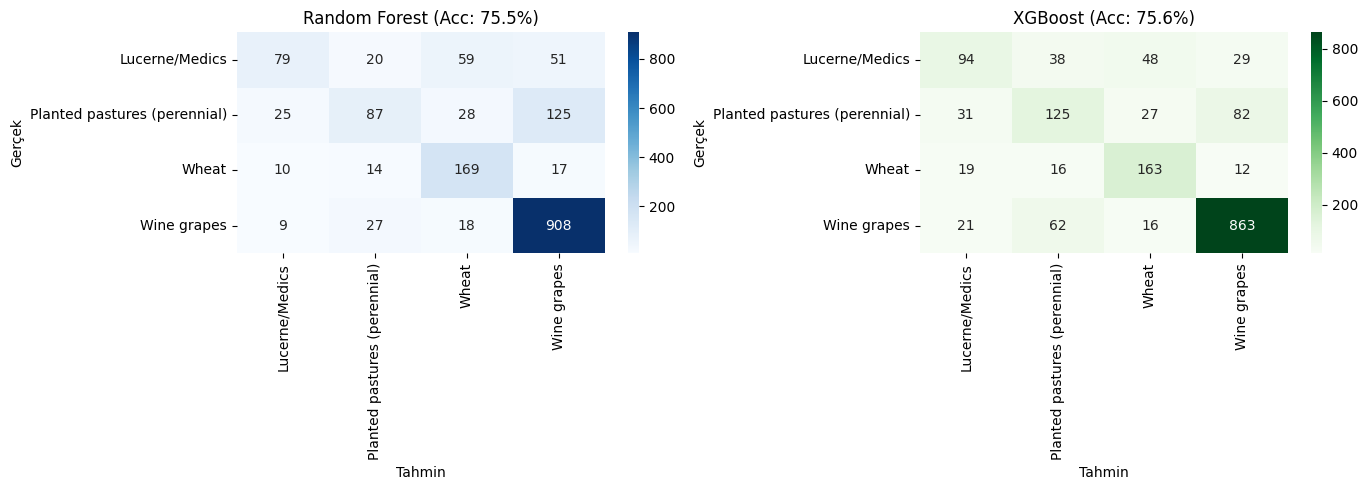

✅ Confusion matrices kaydedildi!


In [ ]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[0])
axes[0].set_title(f'Random Forest (Acc: {rf_acc:.1%})')
axes[0].set_ylabel('Gerçek')
axes[0].set_xlabel('Tahmin')

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1])
axes[1].set_title(f'XGBoost (Acc: {xgb_acc:.1%})')
axes[1].set_ylabel('Gerçek')
axes[1].set_xlabel('Tahmin')

plt.tight_layout()
plt.savefig(FIG_DIR / 'confusion_matrices_100tiles.png', dpi=300)
plt.show()

print("✅ Confusion matrices kaydedildi!")

In [ ]:
# Detaylı raporlar
print("\n🌲 RANDOM FOREST - Sınıf Bazında:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

print("\n🚀 XGBOOST - Sınıf Bazında:")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

# Kaydet
results.to_csv(TAB_DIR / 'results_100tiles_15dates.csv', index=False)

with open(TAB_DIR / 'classification_reports_100tiles.txt', 'w') as f:
    f.write("RANDOM FOREST\n")
    f.write("="*80 + "\n")
    f.write(classification_report(y_test, y_pred_rf, target_names=le.classes_))
    f.write("\n\nXGBOOST\n")
    f.write("="*80 + "\n")
    f.write(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

print("\n💾 Tüm sonuçlar kaydedildi!")
print(f"⏰ Tamamlanma: {datetime.now().strftime('%H:%M:%S')}")


🌲 RANDOM FOREST - Sınıf Bazında:
                              precision    recall  f1-score   support

              Lucerne/Medics       0.64      0.38      0.48       209
Planted pastures (perennial)       0.59      0.33      0.42       265
                       Wheat       0.62      0.80      0.70       210
                 Wine grapes       0.82      0.94      0.88       962

                    accuracy                           0.76      1646
                   macro avg       0.67      0.61      0.62      1646
                weighted avg       0.74      0.76      0.73      1646


🚀 XGBOOST - Sınıf Bazında:
                              precision    recall  f1-score   support

              Lucerne/Medics       0.57      0.45      0.50       209
Planted pastures (perennial)       0.52      0.47      0.49       265
                       Wheat       0.64      0.78      0.70       210
                 Wine grapes       0.88      0.90      0.89       962

                    acc